# Radar graph

In [12]:
import numpy as np
import textwrap
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import math
import pandas as pd

https://towardsdatascience.com/how-to-create-and-visualize-complex-radar-charts-f7764d0f3652

https://colab.research.google.com/drive/1YftqOtPkJGIKbPqBQtjyZgikx20G7Z0M?usp=sharing#scrollTo=Jbxbe3jSyv9Z

In [2]:
class ComplexRadar():
    """
    Create a complex radar chart with different scales for each variable
    Parameters
    ----------
    fig : figure object
        A matplotlib figure object to add the axes on
    variables : list
        A list of variables
    ranges : list
        A list of tuples (min, max) for each variable
    n_ring_levels: int, defaults to 5
        Number of ordinate or ring levels to draw
    show_scales: bool, defaults to True
        Indicates if we the ranges for each variable are plotted
    """
    def __init__(self, fig, variables, ranges, n_ring_levels=5, show_scales=True):
        # Calculate angles and create for each variable an axes
        # Consider here the trick with having the first axes element twice (len+1)
        angles = np.arange(0, 360, 360./len(variables))
        axes = [fig.add_axes([0.1,0.1,0.9,0.9], polar=True, label = "axes{}".format(i)) for i in range(len(variables)+1)]
        
        # Ensure clockwise rotation (first variable at the top N)
        for ax in axes:
            ax.set_theta_zero_location('N')
            ax.set_theta_direction(-1)
            ax.set_axisbelow(True)
        
        # Writing the ranges on each axes
        for i, ax in enumerate(axes):

            # Here we do the trick by repeating the first iteration
            j = 0 if (i==0 or i==1) else i-1
            ax.set_ylim(*ranges[j])
            # Set endpoint to True if you like to have values right before the last circle
            grid = np.linspace(*ranges[j], num=n_ring_levels, 
                               endpoint=False)
            gridlabel = ["{}".format(round(x,2)) for x in grid]
            gridlabel[0] = "" # remove values from the center
            lines, labels = ax.set_rgrids(grid, labels=gridlabel, angle=angles[j])
            
            ax.set_ylim(*ranges[j])
            ax.spines["polar"].set_visible(False)
            ax.grid(visible=False)
            
            if show_scales == False:
                ax.set_yticklabels([])

        # Set all axes except the first one unvisible
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            
        # Setting the attributes
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
        self.ax1 = axes[1]
        self.plot_counter = 0
        
        # Draw (inner) circles and lines
        self.ax.yaxis.grid()
        self.ax.xaxis.grid()

        # Draw outer circle
        self.ax.spines['polar'].set_visible(True)
        
        # ax1 is the duplicate of axes[0] (self.ax)
        # Remove everything from ax1 except the plot itself
        self.ax1.axis('off')
        self.ax1.set_zorder(9)
        
        # Create the outer labels for each variable
        l, text = self.ax.set_thetagrids(angles, labels=variables)
        
        # Beautify them
        labels = [t.get_text() for t in self.ax.get_xticklabels()]
        labels = ['\n'.join(textwrap.wrap(l, 15, 
                                          break_long_words=False)) for l in labels]
        self.ax.set_xticklabels(labels)
        
        for t,a in zip(self.ax.get_xticklabels(),angles):
            if a == 0:
                t.set_ha('center')
            elif a > 0 and a < 180:
                t.set_ha('left')
            elif a == 180:
                t.set_ha('center')
            else:
                t.set_ha('right')

        self.ax.tick_params(axis='both', pad=15)


    def _scale_data(self, data, ranges):
        """Scales data[1:] to ranges[0]"""
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            assert (y1 <= d <= y2) or (y2 <= d <= y1)
        x1, x2 = ranges[0]
        d = data[0]
        sdata = [d]
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            sdata.append((d-y1) / (y2-y1) * (x2 - x1) + x1)
        return sdata
        
    def plot(self, data, *args, **kwargs):
        """Plots a line"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kwargs)
        self.plot_counter = self.plot_counter+1
    
    def fill(self, data, *args, **kwargs):
        """Plots an area"""
        sdata = self._scale_data(data, self.ranges)
        self.ax1.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kwargs)
    
    def fill_between(self, data, *args, **kwargs):
        """Plots an area"""
        sdata1 = self._scale_data(data[0], self.ranges)
        sdata2 = self._scale_data(data[1], self.ranges)
        self.ax1.fill_between(self.angle, np.r_[sdata1, sdata1[0]], np.r_[sdata2, sdata2[0]], *args, **kwargs)
        
    def use_legend(self, *args, **kwargs):
        """Shows a legend"""
        self.ax1.legend(*args, **kwargs)
    
    def set_title(self, title, pad=25, **kwargs):
        """Set a title"""
        self.ax.set_title(title,pad=pad, **kwargs)

In [2]:
data = pd.read_csv("acea_svi_results.csv")

In [4]:
data.head(3)

,Name,Agent,State,Notes,User,Tags,Created,Runtime,Sweep,activation,...,s_mse,s_new_cal_error,s_new_cov,s_new_crps,s_new_mse,s_new_width,s_train_time,s_width,train_time,white
0,firm-sweep-303,13191fhd,finished,-,michele-uit,NaN,2023-03-30T23:27:40.000Z,54,c657qoid,tanh,...,0.149754,0.002584,0.111494,0.056838,0.837616,1.146401,0.155830,0.565141,NaN,NaN
1,jumping-sweep-79,13191fhd,finished,-,michele-uit,NaN,2023-03-30T12:23:20.000Z,53,c657qoid,relu,...,0.116027,0.011761,0.064354,0.062513,0.798454,0.461836,0.172936,0.211113,NaN,NaN
2,stellar-sweep-110,13191fhd,finished,-,michele-uit,NaN,2023-03-30T13:57:14.000Z,51,c657qoid,relu,...,0.174039,0.019609,0.153508,0.071338,0.734358,1.209354,0.153755,0.572974,NaN,NaN


In [5]:
data.describe()

,Tags,Runtime,dropout_p,input_scaling,lr,num_chains,num_iterations,num_samples,seed,spectral_radius,...,s_mse,s_new_cal_error,s_new_cov,s_new_crps,s_new_mse,s_new_width,s_train_time,s_width,train_time,white
count,0.0,10.000000,10.0,0.0,10.000000,10.0,10.0,10.0,10.0,0.0,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.0,0.0
mean,NaN,52.900000,0.0,NaN,0.053110,10.0,500.0,1000.0,10.0,NaN,...,0.185937,0.012164,0.107067,0.078598,1.239829,1.105039,0.159120,0.558497,NaN,NaN
std,NaN,1.197219,0.0,NaN,0.015053,0.0,0.0,0.0,0.0,NaN,...,0.040265,0.005878,0.027246,0.014784,0.515979,0.334078,0.009768,0.169233,NaN,NaN
min,NaN,51.000000,0.0,NaN,0.030547,10.0,500.0,1000.0,10.0,NaN,...,0.116027,0.002584,0.064354,0.056838,0.422742,0.461836,0.143522,0.211113,NaN,NaN
25%,NaN,52.250000,0.0,NaN,0.040245,10.0,500.0,1000.0,10.0,NaN,...,0.163035,0.008275,0.089795,0.066413,0.808244,1.013761,0.154274,0.505912,NaN,NaN
50%,NaN,53.000000,0.0,NaN,0.055024,10.0,500.0,1000.0,10.0,NaN,...,0.182927,0.011060,0.106544,0.083131,1.294132,1.102564,0.158191,0.569058,NaN,NaN
75%,NaN,54.000000,0.0,NaN,0.063508,10.0,500.0,1000.0,10.0,NaN,...,0.212901,0.017356,0.115646,0.084802,1.714082,1.193616,0.163263,0.612800,NaN,NaN
max,NaN,54.000000,0.0,NaN,0.074206,10.0,500.0,1000.0,10.0,NaN,...,0.245610,0.020233,0.153508,0.106481,1.813408,1.765293,0.174624,0.881773,NaN,NaN


In [3]:
variable = data.describe()[["m_cal_error","m_width","m_cov","m_mse","m_crps"]].T[["mean"]]
variable1 = data.describe()[["m_cal_error","m_width","m_cov","m_mse","m_crps"]].T[["min","max"]]
variable2 = data.describe()[["m_new_cal_error","m_new_width","m_new_cov","m_new_mse","m_new_crps"]].rename(columns={'m_new_cal_error':'m_cal_error','m_new_width':'m_width','m_new_cov':'m_cov','m_new_mse':'m_mse','m_new_crps':'m_crps'}).T[["min","max"]]

In [4]:
min_max_per_variable = variable1.copy()

In [8]:
variable1

,min,max
m_cal_error,1.183401,2.217376
m_width,2.413929,3.095649
m_cov,0.969045,0.981202
m_mse,0.238281,0.371833
m_crps,0.278214,0.339566


In [9]:
variable2

,min,max
m_cal_error,0.007193,0.021401
m_width,2.869251,4.066238
m_cov,0.940963,0.959266
m_mse,0.752395,2.128568
m_crps,0.274611,0.338097


In [15]:
variable

,mean
m_cal_error,1.830282
m_width,2.835560
m_cov,0.975118
m_mse,0.299564
m_crps,0.311240


In [5]:
min_max_per_variable["min"] = np.minimum(variable1["min"], variable2["min"]).apply(lambda x: int(x))
min_max_per_variable["max"] = np.maximum(variable1["max"], variable2["max"]).apply(lambda x: math.ceil(x))

In [11]:
min_max_per_variable

,min,max
m_cal_error,0,3
m_width,2,5
m_cov,0,1
m_mse,0,3
m_crps,0,1


In [6]:
result = variable.copy()
# result['min2'] = variable2['min']
# result['max2'] = variable2['max']
result = result.T

In [19]:
result

,m_cal_error,m_width,m_cov,m_mse,m_crps
mean,1.830282,2.83556,0.975118,0.299564,0.31124


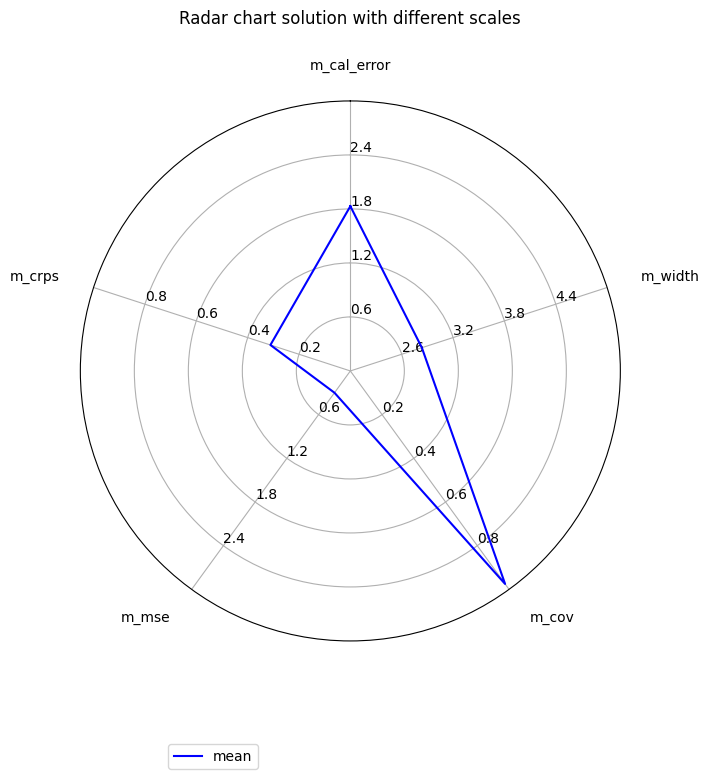

In [20]:
variables = result.columns
ranges = list(min_max_per_variable.itertuples(index=False, name=None))

fig1 = plt.figure(figsize=(6, 6))
radar = ComplexRadar(fig1, variables, ranges, show_scales=True)

colors = ['b','b','r','r']

for g in range(0, len(result.index), 2):
    # label = "pre-calibration" if g<2 else "post-calibration"
    label = "mean"
    radar.plot(result.loc[result.index[g]].values, label=label, color=colors[g])
    # radar.plot(result.loc[result.index[g+1]].values, label='_nolegend_', color=colors[g])
    # radar.fill_between((result.loc[result.index[g]].values,result.loc[result.index[g+1]].values), facecolor=colors[g], alpha=0.25, label='_nolegend_')

radar.set_title("Radar chart solution with different scales")
radar.use_legend(loc='lower left', bbox_to_anchor=(0.15, -0.25),ncol=radar.plot_counter)
plt.show()

# Parallel coordinates

https://en.wikipedia.org/wiki/Parallel_coordinates

https://stackoverflow.com/a/60401570

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import pandas as pd

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 18

In [2]:
# SVI acea
data = {"min":[0.15, 0.927, 2.52, 15.27, 1],
        "max":[0.17, 0.931, 2.56, 15.33, 1],
        "min2":[0.57, 0.80, 0.001, 25.65, 1],
        "max2":[2.11, 0.96, 0.005, 25.83, 1]}

In [2]:
# SVI SPAIN
data = {"min":[0.45321007119598394-0.048050369710414736, 0.3879571347592224-0.02305707237302801, 0.5281323209757274-0.2797781446284038, 3.5527213212733506-0.09397552094984822, 0.972087912087912-0.0034119065266505423],
        "max":[0.45321007119598394+0.048050369710414736, 0.3879571347592224+0.02305707237302801, 0.5281323209757274+0.2797781446284038, 3.5527213212733506+0.09397552094984822, 0.972087912087912+0.0034119065266505423],
        "min2":[0.42010463607927584-0.006629146517314301, 0.39456997621794426-0.017720029430451447, 0.0741081209998792-0.008676188586240665, 3.0942798341735593-0.0845664568783579, 0.9553846153846154-0.0035506581145941965],
        "max2":[0.42010463607927584+0.006629146517314301, 0.39456997621794426+0.017720029430451447, 0.0741081209998792+0.008676188586240665, 3.0942798341735593+0.0845664568783579, 0.9553846153846154+0.0035506581145941965]}

In [69]:
# dropout acea run 8420
data = {"min":[0.1871262264863993-0.022334994014224112, 0.10861938571203478-0.01250993973354438, 2.2881569957882446-0.3718312305560973, 0.2568685279817929-0.027631581821009894, 0.26649543378995433-0.056763407677302986],
        "max":[0.1871262264863993+0.022334994014224112, 0.10861938571203478+0.01250993973354438, 2.2881569957882446+0.3718312305560973, 0.2568685279817929+0.027631581821009894, 0.26649543378995433+0.056763407677302986],
        "min2":[0.18761111393971275-0.022946800784859573, 0.0150142077809052-0.005310764712009526, 0.07333731008875269-0.03282623174237044, 0.041049946909388096-0.013993159632725446, 0.04465372907153729-0.02036960525361073],
        "max2":[0.18761111393971275+0.022946800784859573, 0.0150142077809052+0.005310764712009526, 0.07333731008875269+0.03282623174237044, 0.041049946909388096+0.013993159632725446, 0.04465372907153729+0.02036960525361073]}

In [2]:
# dropout acea run 8766
data = {"min":[1.2512191376706263-0.34410981882240044, 0.6371720655313029-0.0894521292520912, 0.17351750513727585-0.1832698241766968, 4.632021688610562-0.897524928930983, 0.9447488584474886-0.1064877809486352],
        "max":[1.2512191376706263+0.34410981882240044, 0.6371720655313029+0.0894521292520912, 0.17351750513727585+0.1832698241766968, 4.632021688610562+0.897524928930983, 0.9447488584474886+0.1064877809486352],
        "min2":[1.3058472543474429-0.33073173328429933, 0.6294168601909377-0.12034850801464148, 0.03268781825626839-0.004507758655290007, 6.16745486722847-1.9380860283764, 0.9261986301369862-0.1862299362735755],
        "max2":[1.3058472543474429+0.33073173328429933, 0.6294168601909377+0.12034850801464148, 0.03268781825626839+0.004507758655290007, 6.16745486722847+1.9380860283764, 0.9261986301369862+0.1862299362735755]}

In [30]:
# dropout spain run 295
data = {"min":[0.8638325889008872-0.039353342834888845, 0.2623567270937137-0.015045107136093716, 2.4330950307933827-0.14862111584505086, 0.4823021779509421-0.03493662232516165, 0.24505494505494507-0.019065221508678537],
        "max":[0.8638325889008872+0.039353342834888845, 0.2623567270937137+0.015045107136093716, 2.4330950307933827+0.14862111584505086, 0.4823021779509421+0.03493662232516165, 0.24505494505494507+0.019065221508678537],
        "min2":[0.8942573378050873-0.04857497856158323, 0.25878355452689095-0.014572722025272116, 1.161634120275329-0.16811164256963806, 0.788664279520898-0.058197380723722526, 0.381978021978022-0.02997080252084534],
        "max2":[0.8942573378050873+0.04857497856158323, 0.25878355452689095+0.014572722025272116, 1.161634120275329+0.16811164256963806, 0.788664279520898+0.058197380723722526, 0.381978021978022+0.02997080252084534]}

In [34]:
# dropout spain run 2
data = {"min":[0.9440414504912368-0.11875681007277034, 0.4920108442627644-0.052068911768201026, 0.21336248641468428-0.1287783430002587, 2.431701078534864-0.4613299412336664, 0.834065934065934-0.037184449045469525],
        "max":[0.9440414504912368+0.11875681007277034, 0.4920108442627644+0.052068911768201026, 0.21336248641468428+0.1287783430002587, 2.431701078534864+0.4613299412336664, 0.834065934065934+0.037184449045469525],
        "min2":[0.9294188203806042-0.11682385464236078, 0.493135032359715-0.05476148545900019, 0.0350241697862577-0.003144404346924492, 3.625828877866973-0.4963837011117065, 0.9149450549450552-0.014413628511709553],
        "max2":[0.9294188203806042+0.11682385464236078, 0.493135032359715+0.05476148545900019, 0.0350241697862577+0.003144404346924492, 3.625828877866973+0.4963837011117065, 0.9149450549450552+0.014413628511709553]}

In [16]:
# mcmc no dim red acea
data = {"min":[0.6853621889462517-0.3998218091443045, 0.6729795458797574-0.12378335592579016, 1.6987378703619616-0.5369542193946607, 9.642484960666044-5.123982614910528, 0.9945788399883416-0.004325411007657034],
        "max":[0.6853621889462517+0.3998218091443045, 0.6729795458797574+0.12378335592579016, 1.6987378703619616+0.5369542193946607, 9.642484960666044+5.123982614910528, 0.9945788399883416+0.004325411007657034],
        "min2":[5.572835908713657-9.582016969508784, 0.6500159540889097-0.11839040401008682, 1.4287511953394227-1.2720444657216827, 20.017285066679225-14.18861015157478, 0.9994170795686388-0.0006646315506261543],
        "max2":[5.572835908713657+9.582016969508784, 0.6500159540889097+0.11839040401008682, 1.4287511953394227+1.2720444657216827, 20.017285066679225+14.18861015157478, 0.9994170795686388+0.0006646315506261543]}

In [49]:
# mcmc no dim red spain
data = {"min":[1.02150052606676-1.0721657761277148, 0.57977440031648-0.23725837307203929, 0.4388813850984182-0.29779958572015247, 5.945067623654076-2.886546283922636, 0.9661538461538464-0.020877964109077683],
        "max":[1.02150052606676+1.0721657761277148, 0.57977440031648+0.23725837307203929, 0.4388813850984182+0.29779958572015247, 5.945067623654076+2.886546283922636, 0.9661538461538464+0.020877964109077683],
        "min2":[2.881031626835309-2.409468204043344, 0.5612958560407256-0.2406122228198753, 0.038479410699190926-0.023345692832962117, 7.194116933640413-4.289622069340463, 0.9670329670329672-0.027131954922217084],
        "max2":[2.881031626835309+2.409468204043344, 0.5612958560407256+0.2406122228198753, 0.038479410699190926+0.023345692832962117, 7.194116933640413+4.289622069340463, 0.9670329670329672+0.027131954922217084]}

In [21]:
# mcmc with dim red acea
data = {"min":[0.6151270330230489-0.17363750577125237, 0.4400971670604122-0.10957709126541404, 0.4661018548752834-0.06348145338567912, 4.798745585001056-1.9731151681346808, 0.9779428571428572-0.01004833669294501],
        "max":[0.6151270330230489+0.17363750577125237, 0.4400971670604122+0.10957709126541404, 0.4661018548752834+0.06348145338567912, 4.798745585001056+1.9731151681346808, 0.9779428571428572+0.01004833669294501],
        "min2":[0.697748141246716-0.173758210719824, 0.4260246755461366-0.11349454343412092, 0.007693119274376417-0.0025970230141028855, 5.716360271842187-3.1975371486060493, 0.9804190476190476-0.01190523427634264],
        "max2":[0.697748141246716+0.173758210719824, 0.4260246755461366+0.11349454343412092, 0.007693119274376417+0.0025970230141028855, 5.716360271842187+3.1975371486060493, 0.9804190476190476+0.01190523427634264]}

In [53]:
# mcmc with dim red spain
data = {"min":[1.344013064098141-0.39730625660318847, 0.6817018786899769-0.14845452270820267, 0.0960364629875618-0.09892380202037555, 4.765569630118518-1.762706653063686, 0.9147252747252748-0.015689290811054708],
        "max":[1.344013064098141+0.39730625660318847, 0.6817018786899769+0.14845452270820267, 0.0960364629875618+0.09892380202037555, 4.765569630118518+1.762706653063686, 0.9147252747252748+0.015689290811054708],
        "min2":[1.5181164528189266-0.7401657631747651, 0.6585192147806271-0.19335777456669684, 0.015160487863784572-0.002039775624278293, 4.6280456943497565-2.163069422860544, 0.8971428571428571-0.011067849065506967],
        "max2":[1.5181164528189266+0.7401657631747651, 0.6585192147806271+0.19335777456669684, 0.015160487863784572+0.002039775624278293, 4.6280456943497565+2.163069422860544, 0.8971428571428571+0.011067849065506967]}

In [26]:
# ssvs acea
data = {"min":[1.3611559519786949-0.4342473694916216, 2.03364171275579-1.3133681549804117, 2.9474652023218946-0.7838872065567921, 3.0800878104909475-1.9317629603711608, 0.6532206353832702-0.2057733397151771],
        "max":[1.3611559519786949+0.4342473694916216, 2.03364171275579+1.3133681549804117, 2.9474652023218946+0.7838872065567921, 3.0800878104909475+1.9317629603711608, 0.6532206353832702+0.2057733397151771],
        "min2":[1.414520054521796-0.49692035415343344, 2.073975877309851-1.7471773938099144, 3.281267942833702-0.33597116902912083, 4.441272293722601-4.308734798730195, 0.6999125619352958-0.23154334776612467],
        "max2":[1.414520054521796+0.49692035415343344, 2.073975877309851+1.7471773938099144, 3.281267942833702+0.33597116902912083, 4.441272293722601+4.308734798730195, 0.6999125619352958+0.23154334776612467]}

In [57]:
# ssvs spain
data = {"min":[0.5387414324522158-0.041513770329887095, 0.45583973730109106-0.053653041824078256, 0.21266894698707875-0.024115761493324, 3.0750966162622637-0.6524045615915492, 0.9415384615384615-0.011679411213702352],
        "max":[0.5387414324522158+0.041513770329887095, 0.45583973730109106+0.053653041824078256, 0.21266894698707875+0.024115761493324, 3.0750966162622637+0.6524045615915492, 0.9415384615384615+0.011679411213702352],
        "min2":[0.5385924841435645-0.04198586262056173, 0.3993153122019544-0.09277891676685995, 0.028586885641830696-0.0010930371390330434, 2.9304444993545053-0.7228531968944474, 0.9323076923076924-0.016352593615594074],
        "max2":[0.5385924841435645+0.04198586262056173, 0.3993153122019544+0.09277891676685995, 0.028586885641830696+0.0010930371390330434, 2.9304444993545053+0.7228531968944474, 0.9323076923076924+0.016352593615594074]}

In [31]:
# qr acea run 269
data = {"min":[0.1061469316482544-0.001311422442086041, 0.1589135702952164-0.001720997326170403, 0.004482620456667341-0.0029866046108213825, 1.109632968902588-0.02835713326931, 0.9481164383561642-0.0026772455497547825],
        "max":[0.1061469316482544+0.001311422442086041, 0.1589135702952164+0.001720997326170403, 0.004482620456667341+0.0029866046108213825, 1.109632968902588+0.02835713326931, 0.9481164383561642+0.0026772455497547825],
        "min2":[2.1418845653533936-0.010754309594631197, 0.15966175896824708-0.0018204286334408033, 0.05055446887980743-0.0060317909804971, 1.1287903785705566-0.022074054926633835, 0.2952815829528158-0.006857237934147671],
        "max2":[2.1418845653533936+0.010754309594631197, 0.15966175896824708+0.0018204286334408033, 0.05055446887980743+0.0060317909804971, 1.1287903785705566+0.022074054926633835, 0.2952815829528158+0.006857237934147671]}

In [61]:
# qr spain run 115
data = {"min":[0.2905876636505127-0.002222273498773575, 0.28836314267836644-0.005496869946647081, 0.037646799903393355-0.00527976316236584, 1.739101767539978-0.04651648178696632, 0.9134065934065936-0.00805727594717509],
        "max":[0.2905876636505127+0.002222273498773575, 0.28836314267836644+0.005496869946647081, 0.037646799903393355+0.00527976316236584, 1.739101767539978+0.04651648178696632, 0.9134065934065936+0.00805727594717509],
        "min2":[2.3599467277526855-0.014605999924242496, 0.2886298550686862-0.005333103396233239, 0.028632049269411913-0.005054105325127367, 1.6742557287216189-0.050032779574394226, 0.4307692307692309-0.014906219743132464],
        "max2":[2.3599467277526855+0.014605999924242496, 0.2886298550686862+0.005333103396233239, 0.028632049269411913+0.005054105325127367, 1.6742557287216189+0.050032779574394226, 0.4307692307692309+0.014906219743132464]}

In [35]:
result = pd.DataFrame.from_dict(data, orient='index', columns=["MSE","mCRPS","cal","width","coverage"])

In [38]:
result

,MSE,mCRPS,cal,width,coverage
min,0.405153,0.364895,0.248421,3.458785,0.968676
max,0.501268,0.411018,0.808175,3.646738,0.975500
min2,0.312413,0.362633,0.040274,3.738061,0.970227
max2,1.096797,0.397017,0.049145,4.045906,0.978344


In [36]:
# organize the data
ys = result.values
ynames = result.columns
ymins = ys.min(axis=0)
ymaxs = ys.max(axis=0)
dys = ymaxs - ymins
for i in range(len(dys)):
    if dys[i]==0:
        dys[i] = 0.05
ymins -= dys * 0.2  # add 20% padding below and above
ymaxs += dys * 0.2
dys = ymaxs - ymins

# transform all data to be compatible with the main axis
zs = np.zeros_like(ys)
zs[:, 0] = ys[:, 0]
zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

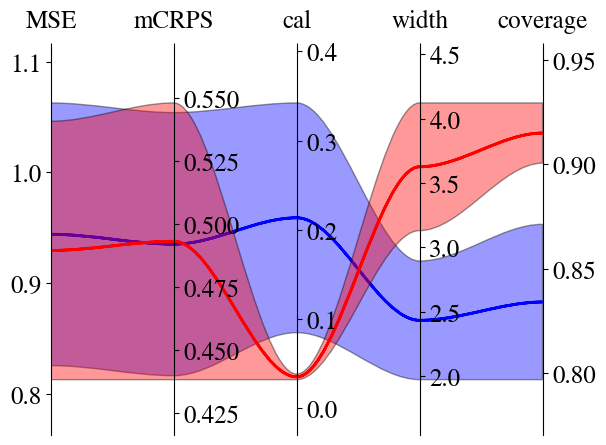

In [37]:
fig, host = plt.subplots()
axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i]) if ymins[i]!=ymaxs[i] else ax.set_ylim(ymins[i]-0.05, ymaxs[i]+0.05)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

host.set_xlim(0, ys.shape[1] - 1)
host.set_xticks(range(ys.shape[1]))
host.set_xticklabels(ynames, fontsize=18)
host.tick_params(axis='x', which='major', pad=7)
host.spines['right'].set_visible(False)
host.xaxis.tick_top()
# host.set_title('Parallel Coordinates Plot', fontsize=18)

colors = ['b','b','r','r']
for j in range(0,4,2):

    # create bezier curves for the standard deviations
    lin = np.linspace(0, ys.shape[1] - 1, ys.shape[1] * 3 - 2, endpoint=True)
    verts = np.concatenate([np.stack([  lin, np.repeat(zs[j, :], 3)[1:-1]]).T,
                            np.flip(np.stack([lin, np.repeat(zs[j+1, :], 3)[1:-1]]).T, axis=0),
                            np.asarray([[lin[0], zs[j,0]]])
                            ])
    # for x,y in verts: host.plot(x, y, 'go') # to show the control points of the beziers
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(int(len(verts)/2) - 1)] + [Path.LINETO] + [Path.CURVE4 for _ in range(int(len(verts)/2) - 1)] + [Path.LINETO]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor=colors[j], alpha=0.4, lw=1, edgecolor=None)
    host.add_patch(patch)
    # add mean path
    mean = np.mean(np.stack([np.repeat(zs[j, :], 3)[1:-1], np.repeat(zs[j+1, :], 3)[1:-1]]),axis=0)
    verts_m = np.concatenate([np.stack([lin, mean]).T,
                            np.flip(np.stack([lin, mean]).T, axis=0),
                            np.asarray([[lin[0], mean[0]]])
                            ])
    codes_m = [Path.MOVETO] + [Path.CURVE4 for _ in range(int(len(verts)/2) - 1)] + [Path.LINETO] + [Path.CURVE4 for _ in range(int(len(verts)/2) - 1)] + [Path.LINETO]
    path_m = Path(verts_m, codes_m)
    patch_m = patches.PathPatch(path_m, facecolor=None, lw=2, edgecolor=colors[j])
    host.add_patch(patch_m)
plt.tight_layout()
plt.show()

In [7]:
np.stack([  lin, np.repeat(zs[j, :], 3)[1:-1]]).T

array([[0.        , 0.41347549],
       [0.33333333, 0.41347549],
       [0.66666667, 0.42939254],
       [1.        , 0.42939254],
       [1.33333333, 0.42939254],
       [1.66666667, 0.4051597 ],
       [2.        , 0.4051597 ],
       [2.33333333, 0.4051597 ],
       [2.66666667, 0.4051597 ],
       [3.        , 0.4051597 ],
       [3.33333333, 0.4051597 ],
       [3.66666667, 0.4051597 ],
       [4.        , 0.4051597 ]])

In [10]:
np.repeat(zs[j, :], 3)[1:-1]

array([0.41347549, 0.41347549, 0.42939254, 0.42939254, 0.42939254,
       0.4051597 , 0.4051597 , 0.4051597 , 0.4051597 , 0.4051597 ,
       0.4051597 , 0.4051597 , 0.4051597 ])

In [11]:
np.repeat(zs[j+1, :], 3)[1:-1]

array([0.42673378, 0.42673378, 0.50126044, 0.50126044, 0.50126044,
       0.40740566, 0.40740566, 0.40740566, 0.43067653, 0.43067653,
       0.43067653, 0.43399625, 0.43399625])

In [14]:
np.mean(np.stack([np.repeat(zs[j, :], 3)[1:-1],
                    np.repeat(zs[j+1, :], 3)[1:-1]]),axis=0)

array([0.42010464, 0.42010464, 0.46532649, 0.46532649, 0.46532649,
       0.40628268, 0.40628268, 0.40628268, 0.41791812, 0.41791812,
       0.41791812, 0.41957798, 0.41957798])